In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle


In [2]:
#A function that calibrate using opencv modual.
def calibrate_camera(cal_images, x, y):
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane

    objp = np.zeros((x*y,3), np.float32)
    objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1, 2) #reshape

    fname = cal_images[0] #Loop through the images
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (x, y), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

In [3]:
#read in the calibration images that perform the function that define above.
cal_images = glob.glob('camera_cal/calibration*.jpg')
x, y = 9, 6
mtx, dist = calibrate_camera(cal_images, x, y)

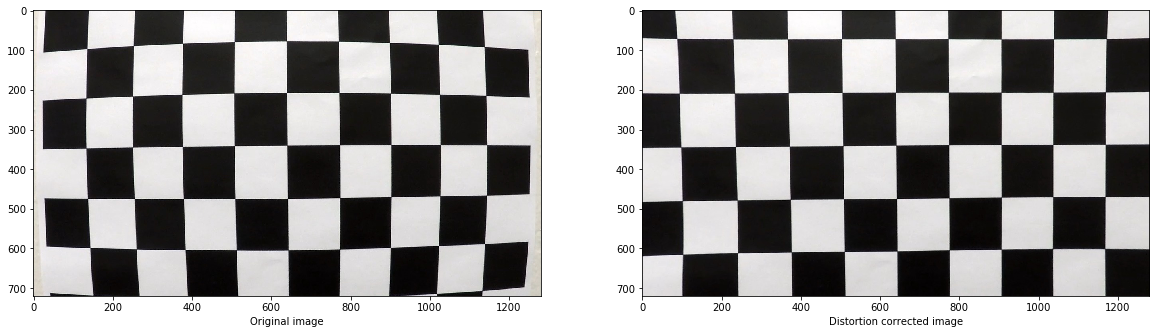

In [4]:
#Test the calibration model by using the first calibration test image.
image = mpimg.imread('camera_cal/calibration1.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.show()

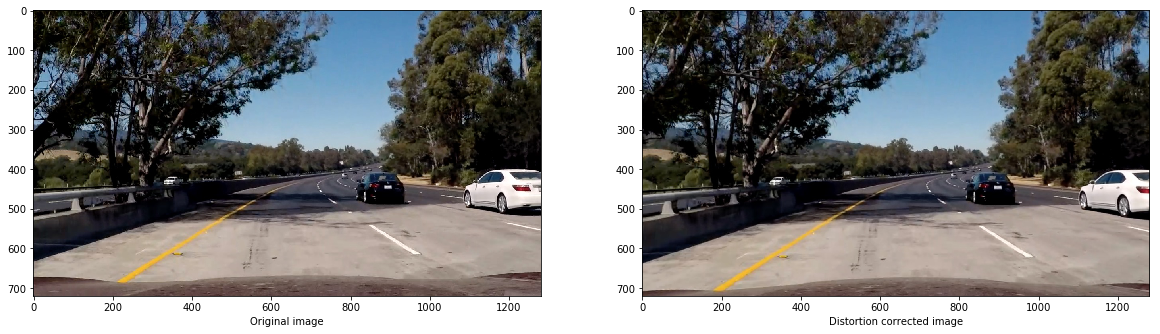

In [5]:
#Calibrate one image from the test_images folder.
image = mpimg.imread('test_images/test5.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.show()

In [6]:
# Define a function to return the direction of the gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
#Define a function to return the threshhold image on saturation channel and using magnitude gradient
def threshold(img):
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    # Dir Mag Threshold
    dir_mask = dir_threshold(img)
    mag_mask = mag_thresh(img)
    combined_binary[((white_mask == 255) | (yellow_mask == 255))|(((dir_mask == 1) & (mag_mask == 1)))] = 255
    combined_binary[(combined_binary == 255)] = 1
    return combined_binary

In [8]:
# Define a function to perform perspective transform
def perspective_transform(img,inv='False'):
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    #location of the four source points
    src = np.float32([[470, 490],[830, 490],[1260, 720],[40, 720]])
    #location of the four destination points
    dst = np.float32([[0, 0],[1280, 0],[1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    if inv=='False':
        warped = cv2.warpPerspective(img, M, img_size) #Perform bird-eye view transformation
    else:
        warped = cv2.warpPerspective(img, Minv, img_size) #Perform the inverse transformation of bird-eye view
        
    return warped

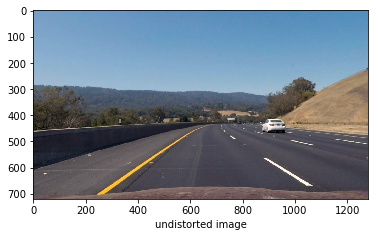

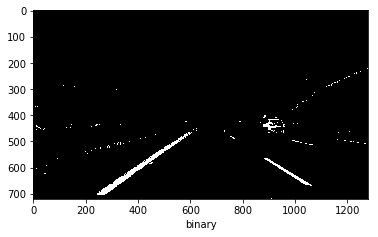

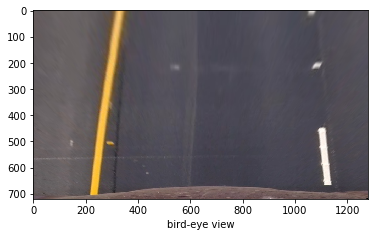

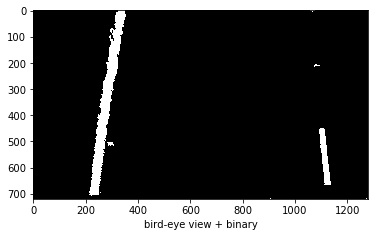

In [9]:
#Visualize the result on a test image
image = mpimg.imread('test_images/test3.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
binary = threshold(undist)
warped=perspective_transform(undist,inv='False')
binary_warped=threshold(warped)

plt.imshow(undist)
plt.xlabel('undistorted image')
plt.show()
plt.imshow(binary,cmap='gray')
plt.xlabel('binary')
plt.show()
plt.imshow(warped)
plt.xlabel('bird-eye view')
plt.show()
plt.imshow(binary_warped,cmap='gray')
plt.xlabel('bird-eye view + binary')
plt.show()

In [10]:
#A function that finds lane lines on a binary warped image
def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)

    # output image background
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # 9 sliding windows
    nwindows = 9
    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

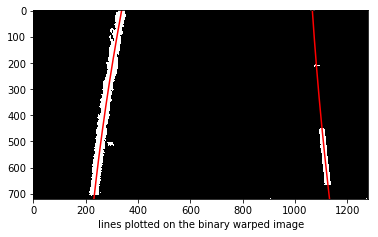

In [12]:
#Get the coefficients from the find_lines function
left_fit, right_fit=find_lines(binary_warped)
#y value
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#x value
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(binary_warped, cmap='gray')
plt.plot(left_fitx, ploty,color='red' )
plt.plot(right_fitx, ploty, color='red')
plt.xlabel('lines plotted on the binary warped image')
plt.show()

In [13]:
#calculate the radius of curvature and distance from center
y_eval = np.max(ploty)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = (((1 + y1*y1)**(1.5))/np.absolute(y2))/1000
print("Radius of Curvature: %.3f km" % curvature)

car_position = binary_warped.shape[1]/2
lane_center_position = (right_fit[2] + left_fit[2]) /2
center_dist = (car_position - lane_center_position) * xm_per_pix
print("Distance from Center: %.3f m" % center_dist)

Radius of Curvature: 3.230 km
Distance from Center: -0.326 m


In [15]:
#Fill up the lane area with green and add text information onto the image
def plot_lane_area(image, left_fitx, right_fitx, ploty,curvature,center_dist):
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    blank_canvas = np.zeros((720, 1280))
    color_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    cv2.fillPoly(color_canvas, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_canvas, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_canvas, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    #inverse transform from the bird-eye view to the original image
    color_canvas_unwarped = perspective_transform(color_canvas, inv='True') 
    combined = cv2.addWeighted(image, 1, color_canvas_unwarped, 0.5, 0)
    
    text = 'Radius of Curvature: ' + '{:04.3f}'.format(curvature) + 'km'
    cv2.putText(combined, text, (40,70),2, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(combined, text, (40,120),2, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return combined

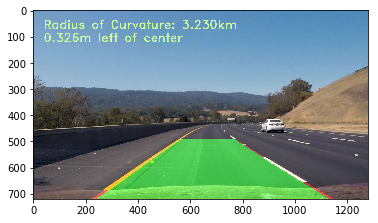

In [16]:
combined=plot_lane_area(image,left_fitx,right_fitx, ploty,curvature,center_dist)
plt.imshow(combined)

In [17]:
#Create a pipeline to include all the necessary steps as shown above
def pipeline(image):

    undist = cv2.undistort(image, mtx, dist, None, mtx)
    warped=perspective_transform(undist,inv='False')
    binary_warped=threshold(warped)
    
    left_fit, right_fit=find_lines(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700.0

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    curvature = (((1 + y1*y1)**(1.5))/np.absolute(y2))/1000
    car_position = binary_warped.shape[1]/2
    lane_center_position = (right_fit[2] + left_fit[2]) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
    combined=plot_lane_area(image,left_fitx,right_fitx, ploty,curvature,center_dist)
    #plt.imshow(combined)
    
    return combined 


In [278]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [279]:
#Create the video output
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:49<00:00,  4.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 42s, sys: 1min 15s, total: 8min 58s
Wall time: 4min 50s
